# Piano Fingering Dataset을 이용하여 손가락 위치 예측

#### 1. 데이터 불러오기 및 전처리

##### GitHub에서 데이터 불러오기

In [132]:
!rm -f raws.zip*
!wget https://github.com/OrigamiDream/piano-fingering-classifier/raw/main/raws.zip # It's me!
!unzip -qq -o raws.zip

--2021-12-03 15:47:54--  https://github.com/OrigamiDream/piano-fingering-classifier/raw/main/raws.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/OrigamiDream/piano-fingering-classifier/main/raws.zip [following]
--2021-12-03 15:47:54--  https://raw.githubusercontent.com/OrigamiDream/piano-fingering-classifier/main/raws.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960170 (938K) [application/zip]
Saving to: ‘raws.zip’

raws.zip            100%[===================>] 937.67K  --.-KB/s    in 0.02s   

2021-12-03 15:47:55 (39.0 MB/s) - ‘raws.zip’ saved [960170/960170]



##### 필요한 라이브러리 불러오기

In [118]:
import os
import glob
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Embedding, Dropout, BatchNormalization, Add
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model, load_model

#### 영어 음이름을 MIDI코드로 변경해 주는 함수 선언

- C4 -> 60
- A0 -> 21
- C8 -> 108 등

In [3]:
pitch_dicts = {'C': 0, 'D': 2, 'E': 4, 'F': 5, 'G': 7, 'A': 9, 'B': 11}

def map_pitch(spelled_pitch):
    assert 2 <= len(spelled_pitch) <= 3
    if len(spelled_pitch) == 3:
        semitone = True
    else:
        semitone = False
    note_name = spelled_pitch[0]
    octave = int(spelled_pitch[-1]) - 4  # C4
    pitch_num = pitch_dicts[note_name]
    if semitone:
        tone = spelled_pitch[1]
        if tone == 'b':  # flat
            pitch_num -= 1
        elif tone == '#':  # sharp
            pitch_num += 1
    return octave * 12 + pitch_num + 60  # 1 octave = 12 pitches, C4 = 60

assert map_pitch('C4') == 60
assert map_pitch('A0') == 21
assert map_pitch('C8') == 108


##### `raws` 폴더에 있는 파일을 CSV포맷에 맞춰 처리 후 `combined` 폴더로 이동하는 함수 선언

In [4]:
def preprocess_raw_datasets(from_dirpath='raws', to_dirpath='combined'):
    if not os.path.exists(from_dirpath):
        raise RuntimeError('`{}` directory must be existed.'.format(from_dirpath))

    files = os.listdir(from_dirpath)

    distinct_names = [filename.split('-')[0] for filename in files if '.txt' in filename]
    distinct_names = list(set(distinct_names))  # remove duplicates
    distinct_names.sort()  # sort alphabetically

    if os.path.exists(to_dirpath):
        shutil.rmtree(to_dirpath)
    os.mkdir(to_dirpath)

    print('Preparing {} files in a row'.format(len(files)))
    succeeded = 0
    for name in distinct_names:
        eligible_files = [filename for filename in files if filename.startswith(f'{name}-')]
        eligible_files.sort()  # sort alphabetically

        for index, eligible_file in enumerate(eligible_files):
            dst_filepath = os.path.join(to_dirpath, f'{name}-v{index + 1}.csv')
            src_filepath = os.path.join(from_dirpath, eligible_file)
            with open(src_filepath, 'r') as src_file:
                lines = src_file.readlines()
                if lines[0].startswith('//'):
                    lines.pop(0)
                if not lines[-1].endswith('\n'):
                    lines[-1] += '\n'
            with open(dst_filepath, 'w') as dst_file:
                for line in lines:
                    dst_file.write(line.replace('\t', ','))
            succeeded += 1
    print('Combined separated files into {} files'.format(succeeded))


##### CSV파일을 전처리하는 함수 선언

1. `channel` == 0, `finger_number` 에 `-`가 없는 데이터를 골라내기 — 오른손 정보만 추출
2. `4_1` 처럼 연주 중간에 손가락 위치가 바뀌는 경우 시간대를 두 개로 나눠 `4`와 `1` 각각 분리
3. 영어 음이름(C4, A#0, Cb8 등)을 MIDI코드로 변환
4. 겹치는 시간대의 코드들을 한 row에 병합
  - 한 번에 연주해야하는 음이 5개(사람의 한 손가락 수)를 초과 시 해당하는 악보 제외
5. 동시에 활성화된 손가락 번호들을 0과 1로 인코딩

In [5]:
def preprocess_csv(filepath):
    df = pd.read_csv(filepath, header=None)
    df.columns = ['note_id', 'onset_time', 'offset_time', 'spelled_pitch', 'onset_velocity', 'offset_velocity', 'channel', 'finger_number']
    df['finger_number'] = df['finger_number'].astype('str')

    mask = (df['channel'] == 0) & (~df['finger_number'].str.contains('-'))  # right-hand only
    df_RH = df[mask]
    # df_RH.head(10)

    necessary_columns = ['note_id', 'onset_time', 'offset_time', 'spelled_pitch', 'finger_number']
    df = df_RH[necessary_columns].copy()
    df['time_diff'] = (df['offset_time'] - df['onset_time']) / 2
    df_subs = df[df['finger_number'].astype('str').str.contains('_')].copy()

    df.drop(df_subs.index, inplace=True)  # drop finger substitution row
    # df.head(15)

    new_lines = []
    for i, index in enumerate(df_subs.index):
        sr = df_subs.iloc[i, :]
        finger_subs = sr['finger_number'].split('_')
        if len(finger_subs[1]) > 0:
            new_line = pd.DataFrame({
                'note_id': sr['note_id'],
                'onset_time': sr['onset_time'] + sr['time_diff'],
                'offset_time': sr['offset_time'],
                'spelled_pitch': sr['spelled_pitch'],
                'finger_number': finger_subs[1],
                'time_diff': 0.0
            }, index=[float(index) + 0.5])
            new_lines.append(new_line)
        else:
            print('Warning: Invalid finger substitution in \'{}\' on time {}: {}'.format(filepath, sr['onset_time'], sr['finger_number']))

        df_subs.iloc[i, 4] = finger_subs[0]  # finger_number
        df_subs.iloc[i, 2] = sr['onset_time'] + sr['time_diff'] - 0.000001
    for new_line in new_lines:
        df_subs = df_subs.append(new_line, ignore_index=False)
    df = df.append(df_subs, ignore_index=False)
    df = df.sort_index().reset_index(drop=True)
    df.drop(['note_id', 'time_diff'], inplace=True, axis=1)

    df['finger_number'] = df['finger_number'].astype('uint8')
    # df.head(15)

    df['pitch'] = df['spelled_pitch'].map(map_pitch)
    df = df[['onset_time', 'offset_time', 'spelled_pitch', 'pitch', 'finger_number']]
    # df.head(15)

    data_y = pd.DataFrame()
    data_X = pd.DataFrame()

    max_combined_notes = 0
    prev_df_notes = None
    for index in df.index:
        sr = df.iloc[index, :]
        onset_time = sr['onset_time']

        mask = (df['onset_time'] <= onset_time) & (df['offset_time'] > onset_time)
        df_notes = df[mask]
        if prev_df_notes is not None and prev_df_notes.equals(df_notes):
            continue
        else:
            prev_df_notes = df_notes

        max_combined_notes = max(max_combined_notes, len(df_notes))
        if max_combined_notes > 5:
            return None, None, ('over_5_fingers', max_combined_notes, df_notes.copy())

        pitches = df_notes['pitch'].values
        row_X = {}
        for i in range(128):
            row_X['{}'.format(i)] = 1 if i in pitches else 0

        fingers = df_notes['finger_number']
        keys = ['first', 'second', 'third', 'fourth', 'fifth']
        values = [0, 0, 0, 0, 0]
        for finger in fingers:
            values[finger - 1] = 1
        row_y = dict(zip(keys, values))

        data_X = data_X.append(row_X, ignore_index=True)
        data_y = data_y.append(row_y, ignore_index=True)

    data_X = data_X.astype('uint8')

    return data_X, data_y, None


In [41]:
ds_dirpath = 'combined'
timesteps = 10
ds_limit = None  # Number of sheets to be used for Datasets, None for all

#### 전처리 수행

##### 1. TXT파일을 CSV파일로 변환

In [42]:
preprocess_raw_datasets('raws', ds_dirpath)  # moves raw datasets into combined datasets

Preparing 309 files in a row
Combined separated files into 309 files


##### 2. 전처리 수행 후 `TimeseriesGenerator`를 이용하여 시계열 데이터 청크 생성

In [43]:
datasets = {
    'X': [],
    'y': []
}

for count, globed_file in enumerate(glob.glob(os.path.join(ds_dirpath, '*.csv'))):
    if ds_limit is not None and count >= ds_limit:
        break
    ds_X, ds_y, failure = preprocess_csv(globed_file)  # preprocess csv files into DataFrame format
    if failure is not None:
        failure_reason = failure[0]
        if failure_reason == 'over_5_fingers':
            max_combined_notes, dataframe = failure[1:]
            print('Warning: File \'{}\' needs to use {} fingers at the same time. Skipped.'.format(globed_file, max_combined_notes))
            print('DataFrame:')
            print('\n'.join([' >> {}'.format(line) for line in dataframe.to_string().split('\n')]))
        continue
    ds_y.drop(ds_y.head(timesteps - 1).index, inplace=True)  # drop first `timesteps` rows

    finger_keys = ['first', 'second', 'third', 'fourth', 'fifth']
    new_rows = {}
    for key in finger_keys:
        new_rows[key] = np.zeros(timesteps - 1, dtype=np.uint8)
    new_df = pd.DataFrame(new_rows)

    ds_y = pd.concat([ds_y, new_df])  # append `timesteps` empty rows
    ds_y = ds_y.reset_index(drop=True)

    data_iter = TimeseriesGenerator(ds_X.to_numpy(),
                                    ds_y.to_numpy(),
                                    length=timesteps,
                                    batch_size=1,
                                    shuffle=False)

    for i in range(len(data_iter)):
        ts_X, ts_y = data_iter[i]
        datasets['X'].append(np.reshape(ts_X, (timesteps, 128)))
        datasets['y'].append(np.reshape(ts_y, (5,)))

datasets['X'] = np.array(datasets['X'])
datasets['y'] = np.array(datasets['y'])

train_X, test_X, train_y, test_y = train_test_split(datasets['X'], datasets['y'], test_size=0.3)
train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, test_size=0.2)

print('Finished preprocessing and splitting into training, validation and testing set.')

DataFrame:
 >>     onset_time  offset_time spelled_pitch  pitch  finger_number
 >> 49     21.1501      22.2793           F#3     54              1
 >> 50     21.1501      22.2359           G#3     56              1
 >> 51     21.1501      22.2359            C4     60              2
 >> 52     21.1501      22.2359           G#4     68              5
 >> 53     21.1501      21.9883            E4     64              4
 >> 54     21.9568      22.1979           Eb4     63              4
DataFrame:
 >>      onset_time  offset_time spelled_pitch  pitch  finger_number
 >> 152     28.1723      28.6626            E5     76              2
 >> 153     28.1723      28.6626            G5     79              3
 >> 155     28.4117      28.6532           Bb4     70              1
 >> 156     28.6443      28.8835           G#4     68              1
 >> 157     28.6443      28.8835            B4     71              2
 >> 158     28.6443      28.8835            F5     77              4
 >> 159     28.6443

In [44]:
print('Training Set:', train_X.shape, train_y.shape)
print('Validation Set:', valid_X.shape, valid_y.shape)
print('Testing Set:', test_X.shape, test_y.shape)

Training Set: (22108, 10, 128) (22108, 5)
Validation Set: (5527, 10, 128) (5527, 5)
Testing Set: (11844, 10, 128) (11844, 5)


In [25]:
def flatten_timeseries(data):
    # flatten timeseries data to be fit to KNeighborsClassifier
    return np.reshape(data, (len(data), timesteps * 128))

#### GridSearch 시행 및 플롯 생성 함수 선언

In [116]:
def perform_grid_search(ds, sklearn_classifier_type, kmax=20):
    params = {
        'n_neighbors': np.arange(1, kmax + 1)
    }
    model = sklearn_classifier_type()
    gs = GridSearchCV(model, param_grid=params, cv=10, n_jobs=-1)
    gs.fit(flatten_timeseries(train_X), train_y)

    plt.plot(gs.cv_results_['mean_test_score'])
    plt.legend()
    plt.xlabel('K')
    plt.ylabel('scores')

    ticks = params['n_neighbors']
    ticks = [ticks.min(), gs.best_estimator_.n_neighbors, ticks.max()]
    plt.xticks([x - 1 for x in ticks], ticks)
    plt.show()
    return gs.best_estimator_

#### 알고리즘 테스트

##### K값을 1부터 10까지 설정하여 `KNeighborsClassifier`로 정확도 측정

No handles with labels found to put in legend.


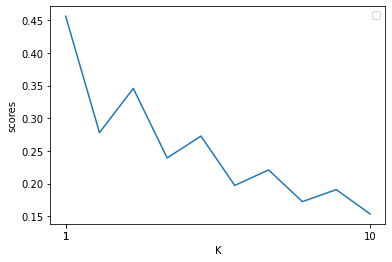

In [117]:
# GridSearch KNeighborsClassifier with kmax=10
best_estimator = perform_grid_search(datasets, KNeighborsClassifier, kmax=10)  # Best Hyperparameter K is 1

##### `LSTM`으로 정확도 측정

In [112]:
input_layer = Input(shape=(timesteps, 128))
x = input_layer
x = LSTM(256, kernel_initializer='he_normal', return_sequences=True)(x)
x = LSTM(256, kernel_initializer='he_normal')(x)
x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
output_layer = Dense(5, activation='sigmoid')(x)
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss=BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [113]:
filepath = 'best_weights_lstm.hdf5'
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=20, verbose=True),
    ModelCheckpoint(filepath, monitor='val_accuracy', verbose=True, save_best_only=True)
]

probe = model.fit(train_X,
                  train_y,
                  batch_size=512,
                  verbose=0,
                  epochs=500,
                  callbacks=callbacks,
                  validation_data=(valid_X, valid_y))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)



Epoch 00001: val_accuracy improved from -inf to 0.26904, saving model to best_weights_lstm.hdf5

Epoch 00002: val_accuracy improved from 0.26904 to 0.28316, saving model to best_weights_lstm.hdf5

Epoch 00003: val_accuracy improved from 0.28316 to 0.28931, saving model to best_weights_lstm.hdf5

Epoch 00004: val_accuracy did not improve from 0.28931

Epoch 00005: val_accuracy improved from 0.28931 to 0.29021, saving model to best_weights_lstm.hdf5

Epoch 00006: val_accuracy improved from 0.29021 to 0.30812, saving model to best_weights_lstm.hdf5

Epoch 00007: val_accuracy improved from 0.30812 to 0.32857, saving model to best_weights_lstm.hdf5

Epoch 00008: val_accuracy did not improve from 0.32857

Epoch 00009: val_accuracy improved from 0.32857 to 0.33309, saving model to best_weights_lstm.hdf5

Epoch 00010: val_accuracy did not improve from 0.33309

Epoch 00011: val_accuracy did not improve from 0.33309

Epoch 00012: val_accuracy improved from 0.33309 to 0.33653, saving model to be

In [114]:
model.evaluate(test_X, test_y)

371/371 [==============================] - 2s 4ms/step - loss: 0.8608 - accuracy: 0.4424


[0.8607692718505859, 0.44241809844970703]

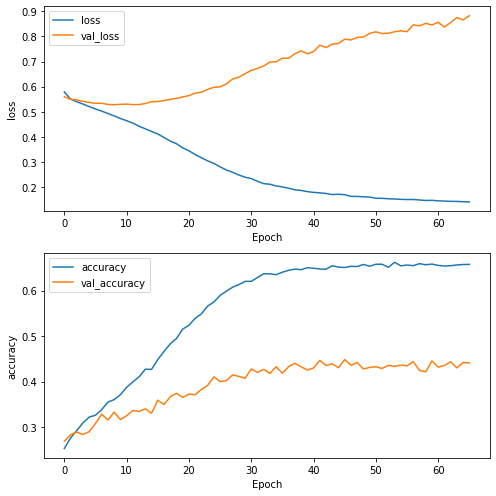

In [115]:
keys = probe.history.keys()
groups = ['loss', 'accuracy']
fig = plt.figure(figsize=(7, 7))
for index, group in enumerate(groups):
    ax = fig.add_subplot(len(groups), 1, index + 1)
    eligible_keys = [key for key in keys if group in key]
    for key in eligible_keys:
        ax.plot(probe.history[key], label=key)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(group)
    ax.legend(loc='best')
plt.tight_layout()
plt.show()

##### `Stacked Bidirectional-LSTM`으로 정확도 측정

In [84]:
input_layer = Input(shape=(timesteps, 128))
x = input_layer
x = Bidirectional(LSTM(2048, kernel_initializer='he_normal', return_sequences=True))(x)
x = Bidirectional(LSTM(2048, kernel_initializer='he_normal'))(x)
x = Dense(4096, activation='relu', kernel_initializer='he_normal')(x)
x = Dense(4096, activation='relu', kernel_initializer='he_normal')(x)
output_layer = Dense(5, activation='sigmoid')(x)
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss=BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [85]:
filepath = 'best_weights_bilstm.hdf5'
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=20, verbose=True),
    ModelCheckpoint(filepath, monitor='val_accuracy', verbose=True, save_best_only=True)
]

probe = model.fit(train_X,
                  train_y,
                  batch_size=512,
                  verbose=0,
                  epochs=500,
                  callbacks=callbacks,
                  validation_data=(valid_X, valid_y))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)



Epoch 00001: val_accuracy improved from -inf to 0.25077, saving model to best_weights_bilstm.hdf5

Epoch 00002: val_accuracy improved from 0.25077 to 0.29872, saving model to best_weights_bilstm.hdf5

Epoch 00003: val_accuracy did not improve from 0.29872

Epoch 00004: val_accuracy improved from 0.29872 to 0.31554, saving model to best_weights_bilstm.hdf5

Epoch 00005: val_accuracy did not improve from 0.31554

Epoch 00006: val_accuracy improved from 0.31554 to 0.33653, saving model to best_weights_bilstm.hdf5

Epoch 00007: val_accuracy improved from 0.33653 to 0.35589, saving model to best_weights_bilstm.hdf5

Epoch 00008: val_accuracy did not improve from 0.35589

Epoch 00009: val_accuracy improved from 0.35589 to 0.38647, saving model to best_weights_bilstm.hdf5

Epoch 00010: val_accuracy improved from 0.38647 to 0.41469, saving model to best_weights_bilstm.hdf5

Epoch 00011: val_accuracy did not improve from 0.41469

Epoch 00012: val_accuracy improved from 0.41469 to 0.43966, savi

In [86]:
model.evaluate(test_X, test_y)

371/371 [==============================] - 12s 31ms/step - loss: 1.1803 - accuracy: 0.4593


[1.1803113222122192, 0.4593043029308319]

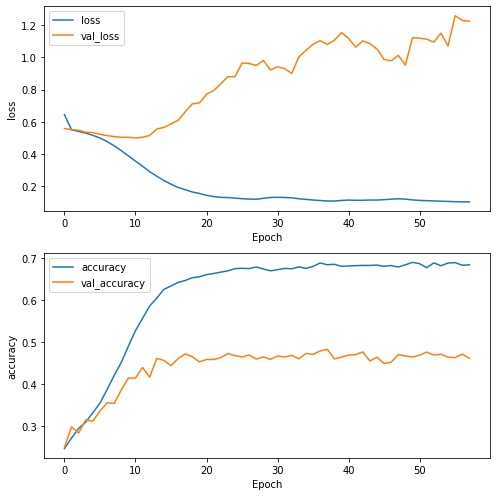

In [87]:
keys = probe.history.keys()
groups = ['loss', 'accuracy']
fig = plt.figure(figsize=(7, 7))
for index, group in enumerate(groups):
    ax = fig.add_subplot(len(groups), 1, index + 1)
    eligible_keys = [key for key in keys if group in key]
    for key in eligible_keys:
        ax.plot(probe.history[key], label=key)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(group)
    ax.legend(loc='best')
plt.tight_layout()
plt.show()

##### 단일 `Bidirectional LSTM`으로 정확도 테스트

In [108]:
input_layer = Input(shape=(timesteps, 128))
x = input_layer
x = Bidirectional(LSTM(4096, kernel_initializer='he_normal'))(x)
output_layer = Dense(5, activation='sigmoid')(x)
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss=BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [109]:
filepath = 'best_weights_dense_bilstm.hdf5'
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=20, verbose=True),
    ModelCheckpoint(filepath, monitor='val_accuracy', verbose=True, save_best_only=True)
]

probe = model.fit(train_X,
                  train_y,
                  batch_size=512,
                  verbose=0,
                  epochs=500,
                  callbacks=callbacks,
                  validation_data=(valid_X, valid_y))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)



Epoch 00001: val_accuracy improved from -inf to 0.27574, saving model to best_weights_dense_bilstm.hdf5

Epoch 00002: val_accuracy did not improve from 0.27574

Epoch 00003: val_accuracy improved from 0.27574 to 0.28279, saving model to best_weights_dense_bilstm.hdf5

Epoch 00004: val_accuracy improved from 0.28279 to 0.28949, saving model to best_weights_dense_bilstm.hdf5

Epoch 00005: val_accuracy improved from 0.28949 to 0.29745, saving model to best_weights_dense_bilstm.hdf5

Epoch 00006: val_accuracy improved from 0.29745 to 0.32332, saving model to best_weights_dense_bilstm.hdf5

Epoch 00007: val_accuracy improved from 0.32332 to 0.34684, saving model to best_weights_dense_bilstm.hdf5

Epoch 00008: val_accuracy improved from 0.34684 to 0.37253, saving model to best_weights_dense_bilstm.hdf5

Epoch 00009: val_accuracy did not improve from 0.37253

Epoch 00010: val_accuracy improved from 0.37253 to 0.39967, saving model to best_weights_dense_bilstm.hdf5

Epoch 00011: val_accuracy 

In [110]:
model.evaluate(test_X, test_y)

371/371 [==============================] - 12s 31ms/step - loss: 0.9563 - accuracy: 0.4587


[0.9562966227531433, 0.45871326327323914]

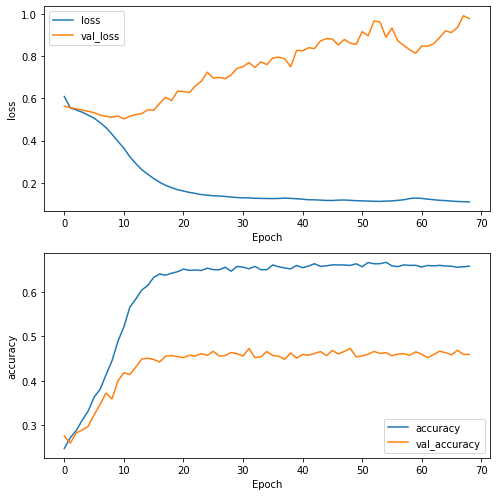

In [111]:
keys = probe.history.keys()
groups = ['loss', 'accuracy']
fig = plt.figure(figsize=(7, 7))
for index, group in enumerate(groups):
    ax = fig.add_subplot(len(groups), 1, index + 1)
    eligible_keys = [key for key in keys if group in key]
    for key in eligible_keys:
        ax.plot(probe.history[key], label=key)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(group)
    ax.legend(loc='best')
plt.tight_layout()
plt.show()

#### 모델별 정확도 비교

In [130]:
model_accuracy = {
    "K-NN": best_estimator.score(flatten_timeseries(test_X), test_y),
    "Stacked LSTM": load_model('best_weights_lstm.hdf5').evaluate(test_X, test_y)[1],
    "Stacked BiLSTM": load_model('best_weights_bilstm.hdf5').evaluate(test_X, test_y)[1],
    "Single BiLSTM": load_model('best_weights_dense_bilstm.hdf5').evaluate(test_X, test_y)[1]
}

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


371/371 [==============================] - 13s 31ms/step - loss: 0.8427 - accuracy: 0.4752


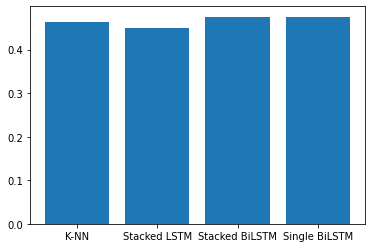

In [131]:
bar_X = np.arange(len(model_accuracy))

plt.bar(bar_X, model_accuracy.values())
plt.xticks(bar_X, model_accuracy.keys())
plt.show()